### Results for imputation on wind_direction (just train)

ratios = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7]

time_imputation = [498.4595172405243, 535.9812779426575, 382.225394487381, 467.5977392196655, 207.57443261146545, 131.66128158569336]
mape_imputation =  [10.661021432629596, 10.66094987616098, 10.534959470297153, 10.601560210130817, 10.578586794722735, 10.578794819419919]
mae_imputation =  [0.15565755190667555, 0.15548198558043402, 0.15398647534098273, 0.15473225996057607, 0.15471727357235873, 0.15473207181873366]
time_prediction =  []
mape_prediction =  [115.09920384958139, 115.10145605712758, 115.22304792014107, 115.20514023106551, 115.29881327654412, 115.46439420994176]
mae_prediction =  [2.411045576079181, 2.411469252298278, 2.4130132029841653, 2.4120047693693074, 2.4130731608806273, 2.4157148375452886]

### Results for imputation on wind_direction (train and test)

ratios = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85]
time_imputation = [760.7768249511719, 833.6295111179352, 331.03947353363037, 210.5356183052063, 100.60632395744324, 69.34340333938599]
mape_imputation =  [10.655264626915809, 10.499994185083757, 10.681917154662534, 10.638655587883045, 10.596149833552735, 10.596493616639869]
mae_imputation =  [0.15591639626159046, 0.153218699400214, 0.15589513935226562, 0.15519977132031357, 0.1550552133342025, 0.1549220600102269]
time_prediction =  []
mape_prediction =  [115.4349735877578, 116.48780259488963, 114.29392445601097, 115.2284456187796, 116.77062778921001, 115.70286894467233]
mae_prediction =  [2.4142372593398025, 2.4023796948936806, 2.4387429669468874, 2.409663312415465, 2.4045725457652907, 2.4021950186983516]

### Results for imputation on precipitations (just train)

ratios = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85]

time_imputation = [334.5759816169739, 220.93195962905884, 223.3536810874939, 218.35092449188232, 75.44321203231812, 58.480687856674194]
mape_imputation =  [2.69251744495105, 2.6656074188353105, 2.7072722875026463, 2.6965653750125296, 2.7166022716786093, 2.7161747234117986]
mae_imputation =  [0.02927843191081118, 0.02888885154555619, 0.029249887627131644, 0.02910631590598334, 0.02934373638911998, 0.02933613892276303]
time_prediction =  []
mape_prediction =  [115.14346397586787, 115.5460603302976, 116.49281661244719, 117.93400404409374, 119.23363228520006, 119.83836222691068]
mae_prediction =  [2.4117583647778793, 2.4172633556710967, 2.430496724987021, 2.4493258274049, 2.466964335067219, 2.4742455842166406]

### Results for imputation on precipitations (train and test)

time_imputation = [345.27573561668396, 278.56666231155396, 304.60888600349426, 165.8144268989563, 97.52951622009277, 48.52631092071533]
mape_imputation =  [2.579436331117188, 2.7146133812855884, 2.701725408799627, 2.6964253859506884, 2.7054057318343734, 2.70623604950047]
mae_imputation =  [0.027640181257082227, 0.029349886855223765, 0.029184162608646508, 0.029177849803427757, 0.029270931863838903, 0.029232264090179393]
time_prediction =  []
mape_prediction =  [114.88637682769046, 116.65396876746904, 118.48552655302022, 118.95122414676707, 119.73960195911792, 119.28144026832175]
mae_prediction =  [2.409019031646397, 2.4180447872986544, 2.422017444721502, 2.4446329493926515, 2.464761624828655, 2.4760137519946217]

## Plot of the imputation quality

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

"""ratios = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85]
percentage_nan = 100 * np.array(ratios)
print(percentage_nan)

time_imputation_wd = [760.7768249511719, 833.6295111179352, 331.03947353363037, 210.5356183052063, 100.60632395744324, 69.34340333938599]
mape_imputation_wd =  [10.655264626915809, 10.499994185083757, 10.681917154662534, 10.638655587883045, 10.596149833552735, 10.596493616639869]
mae_imputation_wd =  [0.15591639626159046, 0.153218699400214, 0.15589513935226562, 0.15519977132031357, 0.1550552133342025, 0.1549220600102269]

time_imputation_p = [345.27573561668396, 278.56666231155396, 304.60888600349426, 165.8144268989563, 97.52951622009277, 48.52631092071533]
mape_imputation_p =  [2.579436331117188, 2.7146133812855884, 2.701725408799627, 2.6964253859506884, 2.7054057318343734, 2.70623604950047]
mae_imputation_p =  [0.027640181257082227, 0.029349886855223765, 0.029184162608646508, 0.029177849803427757, 0.029270931863838903, 0.029232264090179393]"""

ratios = [0.1, 0.25, 0.5, 0.75, 0.85]
percentage_nan = 100 * np.array(ratios)
print(percentage_nan)

time_imputation_wd = [760.7768249511719, 833.6295111179352, 331.03947353363037, 210.5356183052063, 100.60632395744324, 69.34340333938599]
mape_imputation_wd =  [10.655264626915809, 10.499994185083757, 10.681917154662534, 10.638655587883045, 10.596149833552735, 10.596493616639869]
mae_imputation_wd =  [0.15591639626159046, 0.153218699400214, 0.15589513935226562, 0.15519977132031357, 0.1550552133342025, 0.1549220600102269]

time_imputation_p = [345.27573561668396, 278.56666231155396, 304.60888600349426, 165.8144268989563, 97.52951622009277, 48.52631092071533]
mape_imputation_p =  [2.579436331117188, 2.7146133812855884, 2.701725408799627, 2.6964253859506884, 2.7054057318343734, 2.70623604950047]
mae_imputation_p =  [0.027640181257082227, 0.029349886855223765, 0.029184162608646508, 0.029177849803427757, 0.029270931863838903, 0.029232264090179393]


[10. 25. 50. 75. 85.]


In [40]:
data_mae_imputation_wd = pd.DataFrame({'mae_imputation_wd':mae_imputation_wd,
                                        'percentage_nan':percentage_nan})

data_mae_imputation_p = pd.DataFrame({'mae_imputation_p':mae_imputation_p,
                                     'percentage_nan':percentage_nan})

data_mape_imputation_wd = pd.DataFrame({'mape_imputation_wd':mape_imputation_wd,
                                       'percentage_nan':percentage_nan})

data_mape_imputation_p = pd.DataFrame({'mape_imputation_p':mape_imputation_p,
                                      'percentage_nan':percentage_nan})


<AxesSubplot:xlabel='percentage_nan'>

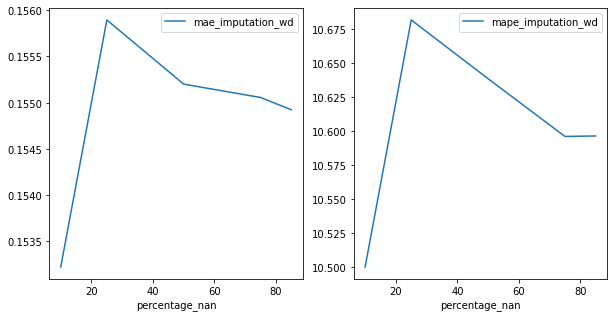

In [41]:
data_mae_imputation_wd.set_index("percentage_nan", inplace=True)
data_mape_imputation_wd.set_index("percentage_nan", inplace=True)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.lineplot(data = data_mae_imputation_wd)

plt.subplot(1,2,2)
sns.lineplot(data = data_mape_imputation_wd)

<AxesSubplot:xlabel='percentage_nan'>

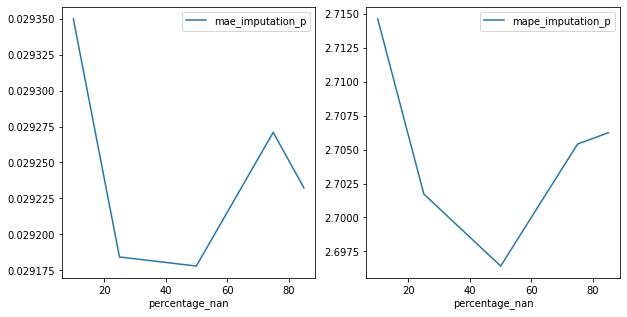

In [42]:
data_mae_imputation_p.set_index("percentage_nan", inplace=True)
data_mape_imputation_p.set_index("percentage_nan", inplace=True)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.lineplot(data = data_mae_imputation_p)

plt.subplot(1,2,2)
sns.lineplot(data = data_mape_imputation_p)

<AxesSubplot:xlabel='percentage_nan'>

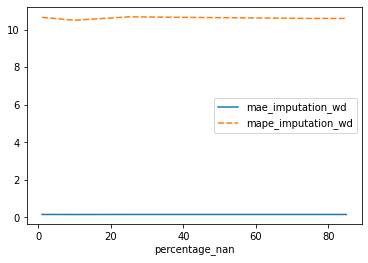

In [18]:
data_time_imputation = pd.DataFrame({'time_imputation_p':time_imputation_p,
                                     'time_imputation_wd':time_imputation_wd,
                                     'percentage_nan':percentage_nan})

<AxesSubplot:xlabel='percentage_nan'>

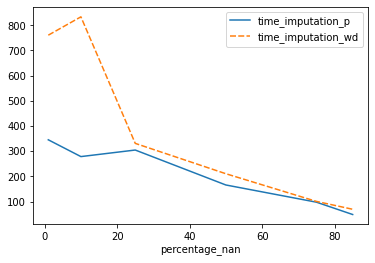

In [19]:
data_time_imputation.set_index("percentage_nan", inplace=True)
sns.lineplot(data = data_time_imputation)

## Plot of the prediction quality

In [45]:
mape_prediction_wd =  [115.4349735877578, 116.48780259488963, 114.29392445601097, 115.2284456187796, 116.77062778921001, 115.70286894467233]
mae_prediction_wd =  [2.4142372593398025, 2.4023796948936806, 2.4387429669468874, 2.409663312415465, 2.4045725457652907, 2.4021950186983516]
mape_prediction_p =  [114.88637682769046, 116.65396876746904, 118.48552655302022, 118.95122414676707, 119.73960195911792, 119.28144026832175]
mae_prediction_p =  [2.409019031646397, 2.4180447872986544, 2.422017444721502, 2.4446329493926515, 2.464761624828655, 2.4760137519946217]

ratios = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85]
percentage_nan = 100 * np.array(ratios)

In [37]:
data_mape_pred = pd.DataFrame({'mape_prediction_wd': mape_prediction_wd,
                               'mape_prediction_p':mape_prediction_p,
                               'percentage_nan':percentage_nan
                               })

data_mae_pred = pd.DataFrame({'mae_prediction_wd': mae_prediction_wd,
                               'mae_prediction_p':mae_prediction_p,
                               'percentage_nan':percentage_nan
                               })

<AxesSubplot:xlabel='percentage_nan'>

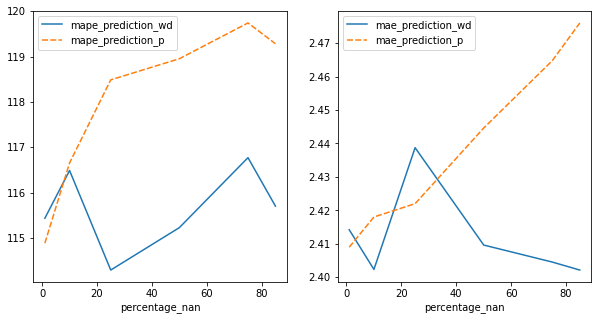

In [38]:
data_mape_pred.set_index("percentage_nan", inplace=True)
data_mae_pred.set_index("percentage_nan", inplace=True)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.lineplot(data = data_mape_pred)

plt.subplot(1,2,2)
sns.lineplot(data = data_mae_pred)



<AxesSubplot:xlabel='percentage_nan'>

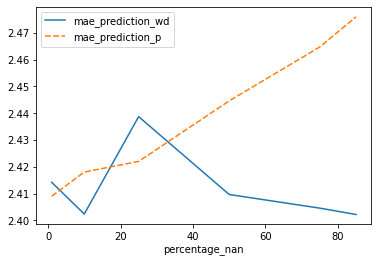

<AxesSubplot:xlabel='percentage_nan'>

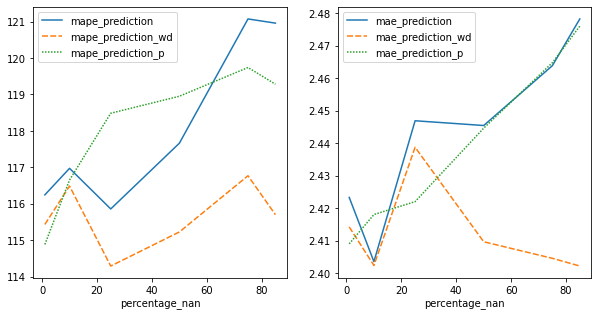

In [46]:
ratios = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85]
percentage_nan = 100 * np.array(ratios)

mape_prediction =  [116.2462489391178, 116.97402480036477, 115.86028393465492, 117.66287169418018, 121.0717496822495, 120.95708945598557]
mae_prediction =  [2.4233133483693496, 2.403547954778829, 2.4469014539249323, 2.4454404092908346, 2.4638451731754847, 2.478234124218667]

data_mape_pred_2 = pd.DataFrame({'mape_prediction': mape_prediction,
                                 'mape_prediction_wd': mape_prediction_wd,
                                 'mape_prediction_p':mape_prediction_p,
                               'percentage_nan':percentage_nan
                               })

data_mae_pred_2 = pd.DataFrame({'mae_prediction': mae_prediction,
                                'mae_prediction_wd': mae_prediction_wd,
                                'mae_prediction_p':mae_prediction_p,
                              'percentage_nan':percentage_nan
                              })

data_mape_pred_2.set_index("percentage_nan", inplace=True)
data_mae_pred_2.set_index("percentage_nan", inplace=True)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.lineplot(data = data_mape_pred_2)

plt.subplot(1,2,2)
sns.lineplot(data = data_mae_pred_2)